# Wrangle Act: Wrangling Twitter Data
### By Julio Uribe

The purpose of this project is to expand on wrangling abilities. In this notebook we will gather data about "weRateDogs" twitter posts from a couple of different sources: using the udacity provided twitter enhanced file for tweet id's, directly pulling from Twitter API, and pulling from udacity's server to look at neural net results in a tsv file. Next we'll assess the data and see how to best structure and combine the data. After that we'll clean as many quality and structural issues we can so that our data will be ready for analysis.

### Setup: Import  Modules

In [110]:
import tweepy
from tweepy import OAuthHandler
import json
import numpy as np
from timeit import default_timer as timer
import pandas as pd
import requests
import os
import creds

# 1) Gather Data

### a) First Source File: Twitter Enhanced file and set up API keys

In [111]:
#load file info into dataframe for tweet id's to use later
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')
#load tweet ids for api extraction
tweet_ids = twitter_archive.tweet_id.values
# set up auth objects using creds py file variables
auth = tweepy.OAuthHandler(creds.consumer_key, creds.consumer_secret)
auth.set_access_token(creds.access_token, creds.access_secret)
#create tweepy api object for requests
api = tweepy.API(auth, wait_on_rate_limit = True)

print (len(tweet_ids))

2356


### b) Second Source File: Query Twitter's API for JSON data

In [ ]:
# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # Loop pauses/resumes at about 900 tweets due to api's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

### c) Load JSON data we got from Twitter API into a cleaner dataframe

In [112]:
#load twitter json file into a pandas dataframe
tweets_json_full = pd.read_json("tweet_json.txt", lines=True)
#tweets_json_full.info()

#create a smaller version of tweets_json_full with only the columns we're interested in
tweets_json = pd.DataFrame(tweets_json_full[['id', 'created_at', 'favorite_count', 'retweet_count', 'full_text', 'extended_entities']])
#tweets_json.head()

### d) Third Source file: Use Requests Module to Load Neural Net Results

In [113]:
r = requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')
with open("image_predictions.tsv", 'wb') as file:
    for chunk in r.iter_content(chunk_size=128):
        file.write(chunk)
#read file back in and create a df for image predictions data     
image_predictions = pd.read_csv("image_predictions.tsv", sep='\t')

# 2) Assessing Data

For this project, we have three dataframes we're currently working with: 
* twitter_archive - imported tweet info from twitter_archive_enhanced.txt provided by udacity. Has tweet IDs, tweet text, ratings, and other information.
* tweets_json - data from twitter API containing retweets, favorited count, tweet text, and more.
* image_predictions - results from neural net. Contains three predictions, image url, number of images, etc.

The three dataframes provide info about the tweets posted from the WeRateDogs twitter profile. We'll do some assessing of the data before we merge these dataframes together. Then we'll clean the data to get the most complete data set we can.

### Tidiness Issues
* twitter_archive has 2356 entries, tweets_json has 2340 entries, and image_predictions has 2075 entries. They all serve the same purpose of giving us more info about individual tweets. Should merge all three
* In 'twitter_archive', the last four columns (doggo, floofer, pupper, puppo) are not always observed and best serve as a category. We should combine these 4 columns into one

### Quality Issues
##### *twitter_archive*
* Doggo, pupper, floofer, puppo cols will become redundant once we add new 'stage' column
* 'None' values are strings but should be NaN values. True for all three tables
* Incorrect and missing names under 'name' column: 'None', 'a', 'the', 'an', etc.
* Rating numerators are under 10 but according to the twitter profile, all ratings should be above 10 and less than 20
* Rating numerators should be float to be more inclusive and account for future ratings
* Ther are rows where the 'rating_denominator' is lower or higher than 10. We need to standardize all rows to be out of 10.
* Timestamp column is in string format instead of datetime.
* 'tweet_id' is currently integer. Should be string object.

##### *tweets_json*
* 'Id' column should be renamed to 'tweet_id' to be consistent with other two dataframes
* duplicate 'created_at' column that is equivalent to twitter_archive 'timestamp' column. We'll keep one
* we'll have duplicate 'full_text' columns as well after merging
* Retweets need to be removed. They start with "RT" in 'full_text' column.

##### *image_predictions*
* Dog breed predictions from the neural net in p1 give us results in inconsistent lower/upper case usage
* We get results from our neural net in p1 that don't include dogs such as 'desktop_computer', 'electric_fan', 'wild_boar'.
* Some prediction of dog breeds aren't actual dog breeds
* Duplicates from same jpg_url need to be removed

### Assessing Code

In [114]:
twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [115]:
twitter_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [116]:
twitter_archive.isnull().sum()

tweet_id                         0
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                        0
source                           0
text                             0
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                   59
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
dtype: int64

In [117]:
type(twitter_archive.timestamp[0])

str

In [118]:
twitter_archive.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [119]:
twitter_archive.name.value_counts()

None         745
a             55
Charlie       12
Oliver        11
Cooper        11
Lucy          11
Lola          10
Penny         10
Tucker        10
Bo             9
Winston        9
the            8
Sadie          8
Buddy          7
Toby           7
an             7
Bailey         7
Daisy          7
Oscar          6
Bella          6
Stanley        6
Jax            6
Jack           6
Koda           6
Dave           6
Rusty          6
Scout          6
Milo           6
Leo            6
Phil           5
            ... 
Glenn          1
Patch          1
Yukon          1
Lili           1
Miguel         1
Shiloh         1
Ruffles        1
Rhino          1
Trip           1
Brutus         1
Rolf           1
Callie         1
Beya           1
Harnold        1
by             1
Billl          1
Bruno          1
Noosh          1
Chubbs         1
Arnold         1
Tycho          1
Koko           1
Hermione       1
Alf            1
Rumpole        1
Clarq          1
Charleson      1
Cermet        

In [120]:
twitter_archive.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [121]:
twitter_archive.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [122]:
tweets_json

,id,created_at,favorite_count,retweet_count,full_text,extended_entities
0,892420643555336193,2017-08-01 16:23:56,37806,8244,This is Phineas. He's a mystical boy. Only eve...,"{'media': [{'id': 892420639486877696, 'id_str'..."
1,892177421306343426,2017-08-01 00:17:27,32488,6091,This is Tilly. She's just checking pup on you....,"{'media': [{'id': 892177413194625024, 'id_str'..."
2,891815181378084864,2017-07-31 00:18:03,24452,4029,This is Archie. He is a rare Norwegian Pouncin...,"{'media': [{'id': 891815175371796480, 'id_str'..."
3,891689557279858688,2017-07-30 15:58:51,41150,8389,This is Darla. She commenced a snooze mid meal...,"{'media': [{'id': 891689552724799489, 'id_str'..."
4,891327558926688256,2017-07-29 16:00:24,39341,9094,This is Franklin. He would like you to stop ca...,"{'media': [{'id': 891327551943041024, 'id_str'..."
5,891087950875897856,2017-07-29 00:08:17,19777,3015,Here we have a majestic great white breaching ...,"{'media': [{'id': 891087942176911360, 'id_str'..."
6,890971913173991426,2017-07-28 16:27:12,11562,1993,Meet Jax. He enjoys ice cream so much he gets ...,"{'media': [{'id': 890971906207338496, 'id_str'..."
7,890729181411237888,2017-07-28 00:22:40,63762,18315,When you watch your owner call another dog a g...,"{'media': [{'id': 890729118844600320, 'id_str'..."
8,890609185150312448,2017-07-27 16:25:51,27182,4146,This is Zoey. She doesn't want to be one of th...,"{'media': [{'id': 890609177319665665, 'id_str'..."
9,890240255349198849,2017-07-26 15:59:51,31161,7159,This is Cassie. She is a college pup. Studying...,"{'media': [{'id': 890240245463175168, 'id_str'..."


In [123]:
tweets_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2339 entries, 0 to 2338
Data columns (total 6 columns):
id                   2339 non-null int64
created_at           2339 non-null datetime64[ns]
favorite_count       2339 non-null int64
retweet_count        2339 non-null int64
full_text            2339 non-null object
extended_entities    2065 non-null object
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 109.7+ KB


In [124]:
tweets_json.isnull().sum()

id                     0
created_at             0
favorite_count         0
retweet_count          0
full_text              0
extended_entities    274
dtype: int64

In [125]:
image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [126]:
image_predictions.isnull().sum()

tweet_id    0
jpg_url     0
img_num     0
p1          0
p1_conf     0
p1_dog      0
p2          0
p2_conf     0
p2_dog      0
p3          0
p3_conf     0
p3_dog      0
dtype: int64

In [127]:
image_predictions.p1.value_counts()

golden_retriever             150
Labrador_retriever           100
Pembroke                      89
Chihuahua                     83
pug                           57
chow                          44
Samoyed                       43
toy_poodle                    39
Pomeranian                    38
cocker_spaniel                30
malamute                      30
French_bulldog                26
miniature_pinscher            23
Chesapeake_Bay_retriever      23
seat_belt                     22
Staffordshire_bullterrier     20
Siberian_husky                20
German_shepherd               20
web_site                      19
Cardigan                      19
Maltese_dog                   18
Eskimo_dog                    18
teddy                         18
Shetland_sheepdog             18
beagle                        18
Shih-Tzu                      17
Rottweiler                    17
Lakeland_terrier              17
kuvasz                        16
Italian_greyhound             16
          

In [128]:
image_predictions.p3.value_counts()

Labrador_retriever                79
Chihuahua                         58
golden_retriever                  48
Eskimo_dog                        38
kelpie                            35
kuvasz                            34
chow                              32
Staffordshire_bullterrier         32
beagle                            31
cocker_spaniel                    31
Pekinese                          29
toy_poodle                        29
Pomeranian                        29
Chesapeake_Bay_retriever          27
Pembroke                          27
Great_Pyrenees                    27
malamute                          26
French_bulldog                    26
American_Staffordshire_terrier    24
Cardigan                          23
pug                               23
basenji                           21
toy_terrier                       20
bull_mastiff                      20
Siberian_husky                    19
Boston_bull                       17
Shetland_sheepdog                 17
b

In [129]:
image_predictions[image_predictions.p3 == 'space_shuttle']

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1240,746906459439529985,https://pbs.twimg.com/media/Cl2LdofXEAATl7x.jpg,1,traffic_light,0.470708,False,fountain,0.199776,False,space_shuttle,0.064807,False


In [130]:
image_predictions[image_predictions.p1 == 'coffee_mug'].jpg_url

1887    https://pbs.twimg.com/media/C8SZH1EWAAAIRRF.jpg
Name: jpg_url, dtype: object

In [131]:
# there's a good chance that a large part of our data set doesn't actually contain dogs in the image, throwing off ratings
image_predictions['p1_dog'].mean(), image_predictions['p2_dog'].mean(), image_predictions['p3_dog'].mean()

(0.7383132530120482, 0.7484337349397591, 0.7224096385542169)

In [132]:
# explore prediction results for tweets with more than one image. How does the neural net handle multiple images?
multi_pic = image_predictions[image_predictions["img_num"] > 1]
multi_pic

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
144,668623201287675904,https://pbs.twimg.com/media/CUdtP1xUYAIeBnE.jpg,4,Chihuahua,0.708163,True,Pomeranian,0.091372,True,titi,0.067325,False
312,671547767500775424,https://pbs.twimg.com/media/CVHRIiqWEAAj98K.jpg,2,Loafer,0.255088,False,platypus,0.090019,False,cowboy_boot,0.066536,False
315,671735591348891648,https://pbs.twimg.com/media/CVJ79MzW4AEpTom.jpg,2,stone_wall,0.271121,False,Irish_wolfhound,0.063078,True,poncho,0.048226,False
319,671768281401958400,https://pbs.twimg.com/media/CVKZsHtWwAA6gPj.jpg,2,Chihuahua,0.500373,True,French_bulldog,0.112796,True,Italian_greyhound,0.062893,True
345,672272411274932228,https://pbs.twimg.com/media/CVRkLuJWUAAhhYp.jpg,2,pug,0.914685,True,Norwegian_elkhound,0.014982,True,Siamese_cat,0.009221,False
381,673317986296586240,https://pbs.twimg.com/media/CVgbIobUYAEaeI3.jpg,2,miniature_pinscher,0.384099,True,bloodhound,0.079923,True,Rottweiler,0.068594,True
382,673320132811366400,https://pbs.twimg.com/media/CVgdFjNWEAAxmbq.jpg,3,Samoyed,0.978833,True,Pomeranian,0.012763,True,Eskimo_dog,0.001853,True
410,673887867907739649,https://pbs.twimg.com/media/CVoha_IU4AAZ7vi.jpg,2,Brabancon_griffon,0.216767,True,Chihuahua,0.190958,True,golden_retriever,0.163288,True
441,674468880899788800,https://pbs.twimg.com/media/CVwx3dQXAAA0ksL.jpg,2,chow,0.526230,True,Pomeranian,0.283647,True,toy_poodle,0.067665,True
452,674752233200820224,https://pbs.twimg.com/media/CV0zkzEU4AAzLc5.jpg,2,vizsla,0.665516,True,redbone,0.173366,True,basset,0.134783,True


In [133]:
# lets compare the average p1_dog, p2_dog, p3_dog rates from multiple images to the whole dataframe
multi_pic['p1_dog'].mean(), multi_pic['p2_dog'].mean(), multi_pic['p3_dog'].mean()
# Multiple images is more likely to have a dog in it than the general dog prediciton rate from entire dataframe

(0.7694915254237288, 0.8101694915254237, 0.8)

In [134]:
#checking for duplicated values
twitter_archive[twitter_archive.tweet_id.duplicated()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [135]:
tweets_json[tweets_json.id.duplicated()]

,id,created_at,favorite_count,retweet_count,full_text,extended_entities


In [136]:
image_predictions[image_predictions.tweet_id.duplicated()]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


In [137]:
image_predictions[image_predictions.jpg_url.duplicated()]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1297,752309394570878976,https://pbs.twimg.com/ext_tw_video_thumb/67535...,1,upright,0.303415,False,golden_retriever,0.181351,True,Brittany_spaniel,0.162084,True
1315,754874841593970688,https://pbs.twimg.com/media/CWza7kpWcAAdYLc.jpg,1,pug,0.272205,True,bull_mastiff,0.251530,True,bath_towel,0.116806,False
1333,757729163776290825,https://pbs.twimg.com/media/CWyD2HGUYAQ1Xa7.jpg,2,cash_machine,0.802333,False,schipperke,0.045519,True,German_shepherd,0.023353,True
1345,759159934323924993,https://pbs.twimg.com/media/CU1zsMSUAAAS0qW.jpg,1,Irish_terrier,0.254856,True,briard,0.227716,True,soft-coated_wheaten_terrier,0.223263,True
1349,759566828574212096,https://pbs.twimg.com/media/CkNjahBXAAQ2kWo.jpg,1,Labrador_retriever,0.967397,True,golden_retriever,0.016641,True,ice_bear,0.014858,False
1364,761371037149827077,https://pbs.twimg.com/tweet_video_thumb/CeBym7...,1,brown_bear,0.713293,False,Indian_elephant,0.172844,False,water_buffalo,0.038902,False
1368,761750502866649088,https://pbs.twimg.com/media/CYLDikFWEAAIy1y.jpg,1,golden_retriever,0.586937,True,Labrador_retriever,0.398260,True,kuvasz,0.005410,True
1387,766078092750233600,https://pbs.twimg.com/media/ChK1tdBWwAQ1flD.jpg,1,toy_poodle,0.420463,True,miniature_poodle,0.132640,True,Chesapeake_Bay_retriever,0.121523,True
1407,770093767776997377,https://pbs.twimg.com/media/CkjMx99UoAM2B1a.jpg,1,golden_retriever,0.843799,True,Labrador_retriever,0.052956,True,kelpie,0.035711,True
1417,771171053431250945,https://pbs.twimg.com/media/CVgdFjNWEAAxmbq.jpg,3,Samoyed,0.978833,True,Pomeranian,0.012763,True,Eskimo_dog,0.001853,True


In [138]:
tweets_json[tweets_json.full_text.str.startswith('RT')]

,id,created_at,favorite_count,retweet_count,full_text,extended_entities
31,886054160059072513,2017-07-15 02:45:48,0,104,RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...,NaN
35,885311592912609280,2017-07-13 01:35:06,0,18012,RT @dog_rates: This is Lilly. She just paralle...,"{'media': [{'id': 830583314243268608, 'id_str'..."
67,879130579576475649,2017-06-26 00:13:58,0,6638,RT @dog_rates: This is Emmy. She was adopted t...,NaN
72,878404777348136964,2017-06-24 00:09:53,0,1252,RT @dog_rates: Meet Shadow. In an attempt to r...,NaN
73,878316110768087041,2017-06-23 18:17:33,0,6482,RT @dog_rates: Meet Terrance. He's being yelle...,NaN
77,877611172832227328,2017-06-21 19:36:23,0,78,RT @rachel2195: @dog_rates the boyfriend and h...,"{'media': [{'id': 876850756556607488, 'id_str'..."
90,874434818259525634,2017-06-13 01:14:41,0,14390,RT @dog_rates: This is Coco. At first I though...,NaN
95,873337748698140672,2017-06-10 00:35:19,0,1554,RT @dog_rates: This is Sierra. She's one preci...,NaN
105,871166179821445120,2017-06-04 00:46:17,0,5612,RT @dog_rates: This is Dawn. She's just checki...,NaN
119,868639477480148993,2017-05-28 01:26:04,0,2081,RT @dog_rates: Say hello to Cooper. His expres...,NaN


# 3) Cleaning Data

### a) Create copies for data

In [139]:
# Create copies of all three dataframes
twitter_archive_clean = twitter_archive.copy()
tweets_json_clean = tweets_json.copy()
image_predictions_clean = image_predictions.copy()

### b) Remove retweets from 'tweets_json'

#### Define
Retweets start with "RT" in the 'full_text' column. We need to search for all retweets programmatically and then create a list of values to drop using the '.drop' pandas function.

#### Code

In [140]:
tweets_json_clean.drop(tweets_json_clean[tweets_json_clean.full_text.str.startswith('RT')].index, inplace=True)

#### Test: Verify no tweets start with 'RT'

In [141]:
tweets_json_clean[tweets_json_clean.full_text.str.startswith('RT')]

,id,created_at,favorite_count,retweet_count,full_text,extended_entities


### c) Remove rows with duplicate image urls from 'image_predictions'

#### Define
Some rows in our 'image_predictions' results use the same url as other rows giving us unnecessary overlap. We must clean the rows by looking for index values that are duplicated across the 'jpg_url' column.

#### Code

In [142]:
image_predictions_clean.drop(image_predictions_clean[image_predictions_clean.jpg_url.duplicated()].index, inplace = True)

#### Test: Verify no duplicate jpg url rows

In [143]:
image_predictions_clean[image_predictions_clean.jpg_url.duplicated()]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


### d) First Merge and Column Name Cleaning

#### Define
Before we merge the dataframes, we wanna relabel the columns for consistency. Then we're going to drop duplicate columns as we merge all three dataframes into one large dataframe we'll call 'tweets_super_clean'. First we'll relabel 'id' to 'tweet_id, 'created_at' to 'timestamp', and 'text' to 'full_text' and merge 'tweets_json' with 'twitter_archive'

#### Code

In [144]:
tweets_json_clean.rename(columns={'id':'tweet_id', 'created_at': 'timestamp'}, inplace=True)
twitter_archive_clean.rename(columns={'text':'full_text', 'created_at': 'timestamp'}, inplace=True)

#### Test

In [145]:
# Make sure column names are consistent when shared/overlapping
twitter_archive_clean.columns, tweets_json_clean.columns

(Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
        'source', 'full_text', 'retweeted_status_id',
        'retweeted_status_user_id', 'retweeted_status_timestamp',
        'expanded_urls', 'rating_numerator', 'rating_denominator', 'name',
        'doggo', 'floofer', 'pupper', 'puppo'],
       dtype='object'),
 Index(['tweet_id', 'timestamp', 'favorite_count', 'retweet_count', 'full_text',
        'extended_entities'],
       dtype='object'))

#### Define
Before merging, I'm gonna drop columns that are less interesting and only keep data that is mostly complete and easy to interpret

#### Code

In [146]:
twitter_archive_clean.drop(['in_reply_to_status_id', 'in_reply_to_user_id', 'source', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp', 'expanded_urls'], axis=1, inplace=True)
tweets_json_clean.drop(['extended_entities'], axis=1, inplace=True)
# Test: Make sure all the appropriate columns have been deleted
twitter_archive_clean.columns, tweets_json_clean.columns

(Index(['tweet_id', 'timestamp', 'full_text', 'rating_numerator',
        'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo'],
       dtype='object'),
 Index(['tweet_id', 'timestamp', 'favorite_count', 'retweet_count',
        'full_text'],
       dtype='object'))

#### Test: Make sure all the appropriate columns have been deleted

In [147]:
twitter_archive_clean.columns, tweets_json_clean.columns

(Index(['tweet_id', 'timestamp', 'full_text', 'rating_numerator',
        'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo'],
       dtype='object'),
 Index(['tweet_id', 'timestamp', 'favorite_count', 'retweet_count',
        'full_text'],
       dtype='object'))

#### Define
First merge. Finally merging 'twitter_enhanced' and 'tweets_json' together on 'tweet_id'

#### Code

In [148]:
tweets_super_clean = tweets_json_clean.merge(twitter_archive_clean, how='inner', on='tweet_id')
# Test: let's see what columns we have now and if the merge is doing what we want it to do

#### Test: let's see what columns we have now and if the merge is doing what we want it to do

In [149]:
tweets_super_clean.head()

,tweet_id,timestamp_x,favorite_count,retweet_count,full_text_x,timestamp_y,full_text_y,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56,37806,8244,This is Phineas. He's a mystical boy. Only eve...,2017-08-01 16:23:56 +0000,This is Phineas. He's a mystical boy. Only eve...,13,10,Phineas,None,None,None,None
1,892177421306343426,2017-08-01 00:17:27,32488,6091,This is Tilly. She's just checking pup on you....,2017-08-01 00:17:27 +0000,This is Tilly. She's just checking pup on you....,13,10,Tilly,None,None,None,None
2,891815181378084864,2017-07-31 00:18:03,24452,4029,This is Archie. He is a rare Norwegian Pouncin...,2017-07-31 00:18:03 +0000,This is Archie. He is a rare Norwegian Pouncin...,12,10,Archie,None,None,None,None
3,891689557279858688,2017-07-30 15:58:51,41150,8389,This is Darla. She commenced a snooze mid meal...,2017-07-30 15:58:51 +0000,This is Darla. She commenced a snooze mid meal...,13,10,Darla,None,None,None,None
4,891327558926688256,2017-07-29 16:00:24,39341,9094,This is Franklin. He would like you to stop ca...,2017-07-29 16:00:24 +0000,This is Franklin. He would like you to stop ca...,12,10,Franklin,None,None,None,None


#### Define
Before we move onto our second merge, we need to remove duplicate columns. 'timestamp_x' and 'timestamp_y' show the same data. 'Timestamp_x is' in the datetime format we want so we'll keep that. We have also need to remove one of the 'full_text' columns as well and relabel them to drop the '_x' portion.

#### Code

In [150]:
# Drop the columns
tweets_super_clean.drop(['timestamp_y', 'full_text_y'], axis=1, inplace=True)
# Rename the columns
tweets_super_clean.rename(columns={'timestamp_x':'timestamp', 'full_text_x': 'full_text'}, inplace=True)

#### Test
Verify our column removal was clean and successful

In [151]:
tweets_super_clean.columns

Index(['tweet_id', 'timestamp', 'favorite_count', 'retweet_count', 'full_text',
       'rating_numerator', 'rating_denominator', 'name', 'doggo', 'floofer',
       'pupper', 'puppo'],
      dtype='object')

### e) Second Merge

#### Define
We'll now merge 'tweets_super_clean' with 'image_predictions' using 'tweet_ids'

#### Code 

In [152]:
tweets_super_clean = tweets_super_clean.merge(image_predictions_clean, on='tweet_id', how='inner')

#### Test

In [153]:
# Confirm successful merge
tweets_super_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1990 entries, 0 to 1989
Data columns (total 23 columns):
tweet_id              1990 non-null int64
timestamp             1990 non-null datetime64[ns]
favorite_count        1990 non-null int64
retweet_count         1990 non-null int64
full_text             1990 non-null object
rating_numerator      1990 non-null int64
rating_denominator    1990 non-null int64
name                  1990 non-null object
doggo                 1990 non-null object
floofer               1990 non-null object
pupper                1990 non-null object
puppo                 1990 non-null object
jpg_url               1990 non-null object
img_num               1990 non-null int64
p1                    1990 non-null object
p1_conf               1990 non-null float64
p1_dog                1990 non-null bool
p2                    1990 non-null object
p2_conf               1990 non-null float64
p2_dog                1990 non-null bool
p3                    1990 non-nu

In [154]:
tweets_super_clean[tweets_super_clean.duplicated()]

,tweet_id,timestamp,favorite_count,retweet_count,full_text,rating_numerator,rating_denominator,name,doggo,floofer,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


### f) Create new category column 'stage' to replace 4 columns: doggo, pupper, floofer, puppo

#### Define
Create new stage column combining the 4 other dog stage columns and use 'mixed' when more than one stage is available.

#### Code

In [155]:
# combine all 4 columns into one new stage column
tweets_super_clean['stage'] = tweets_super_clean['doggo']+tweets_super_clean['floofer']+ \
                    tweets_super_clean['pupper']+tweets_super_clean['puppo']
# remove the None characters from all the strings
tweets_super_clean['stage'] = tweets_super_clean['stage'].str.replace('None', '')
# replace empty strings with NaN values
tweets_super_clean['stage'] = tweets_super_clean['stage'].replace('', np.nan)
# Fix values that include multiple stages and replace with 'mixed'
stages = {'doggopupper': 'mixed',
                'doggopuppo': 'mixed',
                'doggofloofer': 'mixed'}
def find_mixed(tweets_super_clean):
    if tweets_super_clean['stage'] in stages.keys():
        new_stage = stages[tweets_super_clean['stage']]
        return new_stage
    else:
        return tweets_super_clean['stage']    
tweets_super_clean['stage'] = tweets_super_clean.apply(find_mixed, axis=1)

#### Test

In [156]:
# Test: confirm that all stage values are either: pupper, doggo, puppo, floofer, or mixed
tweets_super_clean['stage'].value_counts()

pupper     203
doggo       63
puppo       22
mixed       11
floofer      7
Name: stage, dtype: int64

#### Define
The original four dog stage columns are now unnecessary so we'll go ahead and remove those. We'll also rearrange the order of our columns in our dataframe since we should be done dropping columns and making new ones.

#### Code

In [157]:
# Drop 4 columns that we don't need anymore since all the information is in the 'stage' column
tweets_super_clean.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1, inplace=True)
# rearrange the new stage column before the image prediction columns
tweets_super_clean = tweets_super_clean[['tweet_id', 'timestamp', 'favorite_count', 'retweet_count', 'full_text',
       'rating_numerator', 'rating_denominator', 'name', 'stage', 'jpg_url', 'img_num',
       'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf',
       'p3_dog']]

#### Test

In [158]:
# Confirm dropped columns and new order of columns
tweets_super_clean.head()

,tweet_id,timestamp,favorite_count,retweet_count,full_text,rating_numerator,rating_denominator,name,stage,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,2017-08-01 16:23:56,37806,8244,This is Phineas. He's a mystical boy. Only eve...,13,10,Phineas,NaN,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,2017-08-01 00:17:27,32488,6091,This is Tilly. She's just checking pup on you....,13,10,Tilly,NaN,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2,891815181378084864,2017-07-31 00:18:03,24452,4029,This is Archie. He is a rare Norwegian Pouncin...,12,10,Archie,NaN,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
3,891689557279858688,2017-07-30 15:58:51,41150,8389,This is Darla. She commenced a snooze mid meal...,13,10,Darla,NaN,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
4,891327558926688256,2017-07-29 16:00:24,39341,9094,This is Franklin. He would like you to stop ca...,12,10,Franklin,NaN,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True


### g) Replace 'None' string values with proper NaN values for missing data

#### Define
Replace 'None' values with proper NaN values for missing data

#### Code

In [159]:
tweets_super_clean.replace('None', np.nan, inplace=True)

#### Test

In [160]:
# Test: Confirm changes are reflected in our dataframe
tweets_super_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1990 entries, 0 to 1989
Data columns (total 20 columns):
tweet_id              1990 non-null int64
timestamp             1990 non-null datetime64[ns]
favorite_count        1990 non-null int64
retweet_count         1990 non-null int64
full_text             1990 non-null object
rating_numerator      1990 non-null int64
rating_denominator    1990 non-null int64
name                  1445 non-null object
stage                 306 non-null object
jpg_url               1990 non-null object
img_num               1990 non-null int64
p1                    1990 non-null object
p1_conf               1990 non-null float64
p1_dog                1990 non-null bool
p2                    1990 non-null object
p2_conf               1990 non-null float64
p2_dog                1990 non-null bool
p3                    1990 non-null object
p3_conf               1990 non-null float64
p3_dog                1990 non-null bool
dtypes: bool(3), datetime64[ns](1),

### h) Standardize denominator ratings to be out of 10

#### Define
Reassgin all values in denominator column to a value of 10

#### Code

In [161]:
tweets_super_clean.rating_denominator = 10

#### Test

In [162]:
# should only output '10' in value counts
tweets_super_clean.rating_denominator.value_counts()

10    1990
Name: rating_denominator, dtype: int64

### i) Find incorrect names and replace with NaN values

#### Define
Correct all 'a', 'the', 'an', etc. dog names by replacing them with NaN values. Bad names tend to start with lowercase so we'll put all the lower case names into a list of bad_names and then we'll search our dataframe for these mentions. It should only leave proper names.

#### Code

In [163]:
bad_names = ['None']
# put all the names into a series
names_left = tweets_super_clean.name.value_counts()
for i in names_left.index:
    if i.islower():
        bad_names.append(i)
# iterate through our df and replace bad names with NaN values
for bad_name in bad_names:
    tweets_super_clean.name.replace(bad_name, np.nan, inplace=True)

#### Test

In [164]:
tweets_super_clean.name.value_counts()

Cooper       10
Lucy         10
Oliver       10
Charlie      10
Tucker        9
Penny         9
Winston       8
Sadie         8
Daisy         7
Lola          7
Toby          7
Jax           6
Stanley       6
Bella         6
Bo            6
Koda          6
Leo           5
Chester       5
Milo          5
Louis         5
Dave          5
Scout         5
Rusty         5
Buddy         5
Bailey        5
Oscar         5
Phil          4
Maggie        4
Gary          4
Alfie         4
             ..
Beya          1
Harnold       1
Billl         1
Bruno         1
Mauve         1
Klein         1
Paull         1
Willy         1
Leonard       1
Bauer         1
Severus       1
Maks          1
Sweet         1
Kobe          1
Superpup      1
Zuzu          1
Dug           1
Skittles      1
Bobby         1
Anakin        1
Karl          1
Tess          1
Sully         1
Jeb           1
Naphaniel     1
Goose         1
Mike          1
Tessa         1
Grady         1
Layla         1
Name: name, Length: 912,

### j) Extract new numerator ratings to account for edge cases.

#### Define
Define: Values less than 10 and significantly over 10-19 range should not be valid. I will reassign the numerator using a regex that limits the range its looking for to only contain values from 10-19 and are tied to a '/10'. We will replace the old numerator with this new rating using float as the type.

#### Code

In [165]:
# use regex to create new rating for numerator values
tweets_super_clean['new_rating'] = tweets_super_clean.full_text.str.extract('(1[0-9][.]?[0-9]*?/10)', expand=True)
tweets_super_clean['new_rating'] = tweets_super_clean['new_rating'].str[:-3]
tweets_super_clean['new_rating'] = tweets_super_clean['new_rating'].astype(float)

#### Test

In [166]:
tweets_super_clean.new_rating.value_counts()

12.00      449
10.00      419
11.00      398
13.00      262
14.00       36
1776.00      1
11.27        1
11.26        1
13.50        1
Name: new_rating, dtype: int64

#### Define
We still have one outlier of value '1776'. We'll find it and reassign it to 'NaN' since its not a valid rating.

#### Code

In [167]:
# find the row with the 1776 value
tweets_super_clean[tweets_super_clean['new_rating'] == 1776.0]
# reassign that value with nan since its not in our range
tweets_super_clean.at[796, 'new_rating'] = np.nan

#### Test

In [168]:
# assess all ratings are within intended range
tweets_super_clean.new_rating.value_counts()
tweets_super_clean.head()

,tweet_id,timestamp,favorite_count,retweet_count,full_text,rating_numerator,rating_denominator,name,stage,jpg_url,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,new_rating
0,892420643555336193,2017-08-01 16:23:56,37806,8244,This is Phineas. He's a mystical boy. Only eve...,13,10,Phineas,NaN,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,...,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False,13.0
1,892177421306343426,2017-08-01 00:17:27,32488,6091,This is Tilly. She's just checking pup on you....,13,10,Tilly,NaN,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,...,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,13.0
2,891815181378084864,2017-07-31 00:18:03,24452,4029,This is Archie. He is a rare Norwegian Pouncin...,12,10,Archie,NaN,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,...,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,12.0
3,891689557279858688,2017-07-30 15:58:51,41150,8389,This is Darla. She commenced a snooze mid meal...,13,10,Darla,NaN,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,...,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,13.0
4,891327558926688256,2017-07-29 16:00:24,39341,9094,This is Franklin. He would like you to stop ca...,12,10,Franklin,NaN,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,...,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,12.0


#### Define
Now that our new rating looks good, we'll reassign the original numerator with the new numerator values and we'll drop the 'new_rating'

#### Code

In [169]:
# reassign numerator_rating to new_rating and delete new_rating column
tweets_super_clean['rating_numerator'] = tweets_super_clean['new_rating']
tweets_super_clean.drop(['new_rating'], axis=1, inplace=True)

#### Test

In [170]:
tweets_super_clean.query("rating_numerator == 11.26").full_text.values
tweets_super_clean.query("rating_numerator == 13.50").full_text.values
tweets_super_clean.rating_numerator.value_counts()

12.00      449
10.00      419
11.00      398
13.00      262
14.00       36
1776.00      1
11.27        1
11.26        1
13.50        1
Name: rating_numerator, dtype: int64

### k) Clean up case usage on nueral net predictions. Uppercase first letter of each word

#### Define
p1, p2, p3 all have inconsistent case use with breed predictions. We'll clean up these columns and make sure they're using proper title case (first letter of each word is capitilized).

#### Code

In [171]:
tweets_super_clean.p1 = tweets_super_clean.p1.str.title()
tweets_super_clean.p2 = tweets_super_clean.p2.str.title()
tweets_super_clean.p3 = tweets_super_clean.p3.str.title()

#### Test

In [172]:
# Assess
tweets_super_clean.p1
tweets_super_clean.p2
tweets_super_clean.p3
tweets_super_clean.head()

,tweet_id,timestamp,favorite_count,retweet_count,full_text,rating_numerator,rating_denominator,name,stage,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,2017-08-01 16:23:56,37806,8244,This is Phineas. He's a mystical boy. Only eve...,13.0,10,Phineas,NaN,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,Orange,0.097049,False,Bagel,0.085851,False,Banana,0.076110,False
1,892177421306343426,2017-08-01 00:17:27,32488,6091,This is Tilly. She's just checking pup on you....,13.0,10,Tilly,NaN,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,Papillon,0.068957,True
2,891815181378084864,2017-07-31 00:18:03,24452,4029,This is Archie. He is a rare Norwegian Pouncin...,12.0,10,Archie,NaN,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,Malamute,0.078253,True,Kelpie,0.031379,True
3,891689557279858688,2017-07-30 15:58:51,41150,8389,This is Darla. She commenced a snooze mid meal...,13.0,10,Darla,NaN,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,Paper_Towel,0.170278,False,Labrador_Retriever,0.168086,True,Spatula,0.040836,False
4,891327558926688256,2017-07-29 16:00:24,39341,9094,This is Franklin. He would like you to stop ca...,12.0,10,Franklin,NaN,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,Basset,0.555712,True,English_Springer,0.225770,True,German_Short-Haired_Pointer,0.175219,True


### l) Change 'tweet_id' to object data type instead of int

#### Define
Gonna change the type on 'tweet_id' column to integer

#### Code

In [173]:
tweets_super_clean['tweet_id'] = tweets_super_clean['tweet_id'].astype(str)

#### Test

In [174]:
type(tweets_super_clean.tweet_id[0])

str

### m) Save clean dataframe to CSV file

In [181]:
# save clean df as twitter_archive_master.csv
tweets_super_clean.to_csv('twitter_archive_master.csv', index=False)

# 4) Analyze and Visualize Clean Dataframe

In [182]:
tweets_master = pd.read_csv('twitter_archive_master.csv')
tweets_master.head()

,tweet_id,timestamp,favorite_count,retweet_count,full_text,rating_numerator,rating_denominator,name,stage,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,2017-08-01 16:23:56,37806,8244,This is Phineas. He's a mystical boy. Only eve...,13.0,10,Phineas,NaN,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,Orange,0.097049,False,Bagel,0.085851,False,Banana,0.076110,False
1,892177421306343426,2017-08-01 00:17:27,32488,6091,This is Tilly. She's just checking pup on you....,13.0,10,Tilly,NaN,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,Papillon,0.068957,True
2,891815181378084864,2017-07-31 00:18:03,24452,4029,This is Archie. He is a rare Norwegian Pouncin...,12.0,10,Archie,NaN,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,Malamute,0.078253,True,Kelpie,0.031379,True
3,891689557279858688,2017-07-30 15:58:51,41150,8389,This is Darla. She commenced a snooze mid meal...,13.0,10,Darla,NaN,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,Paper_Towel,0.170278,False,Labrador_Retriever,0.168086,True,Spatula,0.040836,False
4,891327558926688256,2017-07-29 16:00:24,39341,9094,This is Franklin. He would like you to stop ca...,12.0,10,Franklin,NaN,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,Basset,0.555712,True,English_Springer,0.225770,True,German_Short-Haired_Pointer,0.175219,True


### Insights and Visualization

In [183]:
# How many tweets have valid ratings
1 - (tweets_master.rating_numerator.isnull().sum()/(len(tweets_master.rating_numerator)))

0.7879396984924623

In [184]:
# Average number of retweets
tweets_master.retweet_count.mean()

2630.218090452261

In [185]:
# tweet average dog rating
tweets_master.rating_numerator.mean()

12.549764030612245

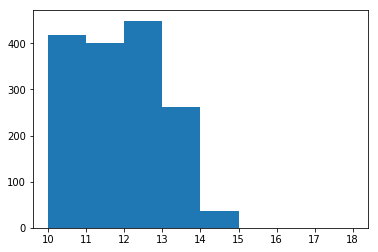

In [188]:
# import visualization modules
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(tweets_master.rating_numerator, bins=[10, 11, 12, 13, 14, 15, 16, 17, 18]);

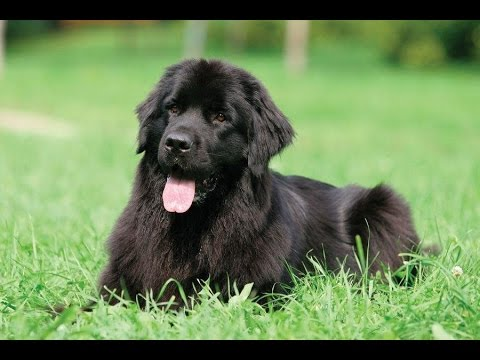

In [212]:
# let me introduce you to my favorite dog breed, Newfoundland
from IPython.display import Image
Image(filename='newfoundland.jpg', width=300, height=300)

In [192]:
# average rating for newfoundland, my favorite dog breed
my_favorite = tweets_master.query("p1 == 'Newfoundland'")
my_favorite.rating_numerator.mean()

11.0

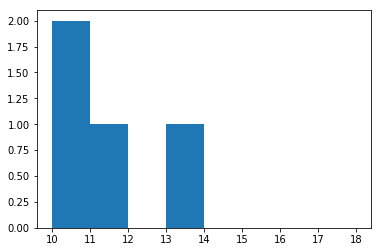

In [197]:
# plot for newfoundland
plt.hist(my_favorite.rating_numerator, bins=[10, 11, 12, 13, 14, 15, 16, 17, 18]);

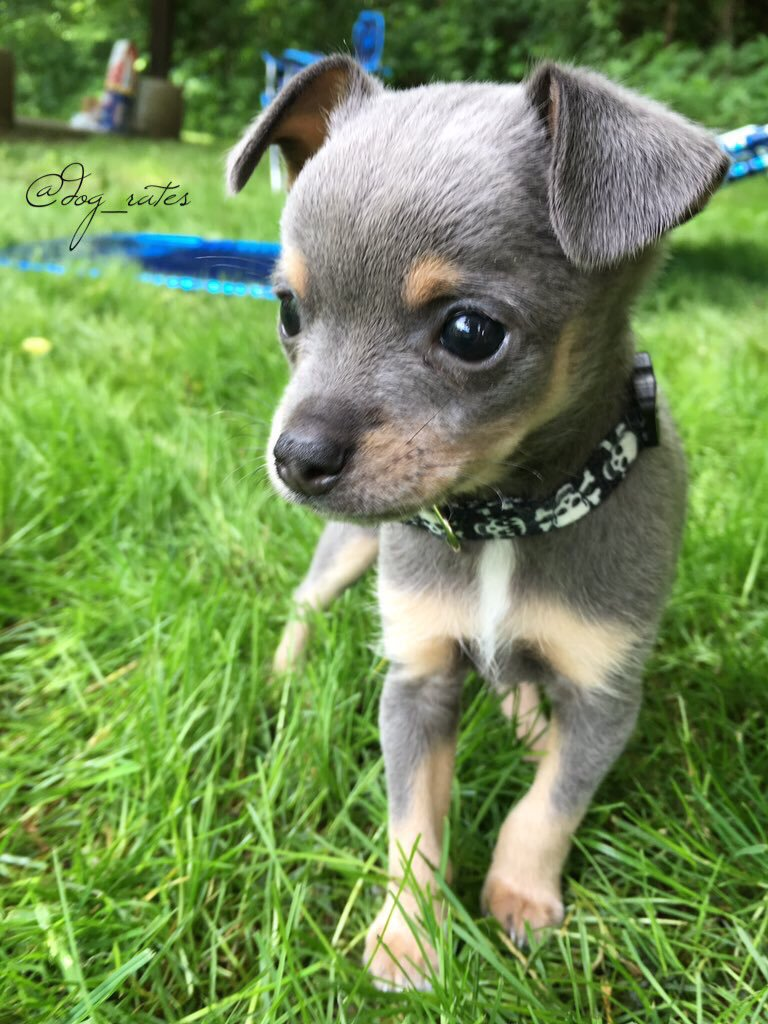

In [215]:
# dataset only with least favorite dog breed
least_favorite = tweets_master.query("p1 == 'Chihuahua'")
# picutre of a chihuahua
Image(filename='chihuahua.jpg', width=300, height=300)

In [195]:
# average rating for my least favorite, Chihuahua
least_favorite.rating_numerator.mean()

11.476190476190476

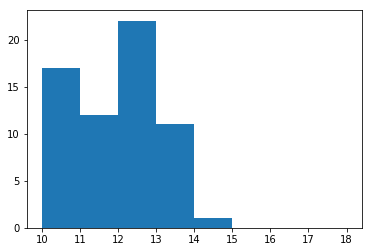

In [198]:
# plot for chihuahua
plt.hist(least_favorite.rating_numerator, bins=[10, 11, 12, 13, 14, 15, 16, 17, 18]);

In [199]:
# average rating for mid size dogs and smaller dogs, doggo vs pupper
print ("The average rating for a doggo is", tweets_master.query("stage == 'doggo'").rating_numerator.mean())
print ("The average rating for a pupper is", tweets_master.query("stage == 'pupper'").rating_numerator.mean())

The average rating for a doggo is 12.083333333333334
The average rating for a pupper is 11.274363636363637
